# H5 generation - rotation, random sampling , normalization


## Visualization function

In [1]:
from visualization import *

## Load dataset

In [2]:
import os

import numpy as np

import pickle


db = {}

"""
Load car data
"""
db['car'] = []
""" file path """
root_path = os.path.abspath('./dataset/point_dataset/4_dense/car/')
    
""" find ".npy" files """
fname = []
for root,d_names,f_names in os.walk(root_path):
    for f in f_names:
        if f.split('.')[-1] == 'npy':
            fname.append(os.path.join(root, f))
            
""" run labeling """
for i in range ( 0, len(fname)):
    db['car'].append(np.load(fname[i]))
    assert len(np.load(fname[i])) != 0
        
    
    
"""
Load pedestrian data
"""
db['pedestrian'] = []
""" file path """
root_path = os.path.abspath('./dataset/point_dataset/4_dense/pedestrian/')
    
""" find ".npy" files """
fname = []
for root,d_names,f_names in os.walk(root_path):
    for f in f_names:
        if f.split('.')[-1] == 'npy':
            fname.append(os.path.join(root, f))
            
""" run labeling """
for i in range ( 0, len(fname)):
    db['pedestrian'].append(np.load(fname[i]))
    assert len(np.load(fname[i])) != 0



    
""" 
Load unknown data 
"""
import pcl

density_list = [0.05, 0.1, 0.15, 0.2, 0.25]

def augmentation_density(pc, density_list):
    
    aug_pc_list = []
    
    for d in density_list:
        
        pcl_pc = pcl.PointCloud(pc.copy().astype(np.float32))
        vgf = pcl_pc.make_voxel_grid_filter()
        vgf.set_leaf_size(d, d, d)
        pcl_pc = vgf.filter()

        aug_pc = np.asarray(pcl_pc)
        
        aug_pc_list.append(aug_pc)

    return aug_pc_list


db['unknown'] = []
""" file path """
load_ndata_path = os.path.abspath('../Dataset_ver2/dataset/ndb_v2_20181020.pickle')
   
with open(load_ndata_path, 'rb') as f:
    ndb = pickle.load(f)
    
for k in ndb:
    
    pcs = ndb[k]
    
    for i in range ( 0, len(pcs) ):
        assert len(pcs[i]) != 0
        
        pc_aug = augmentation_density(pcs[i].copy(), density_list)
        pc_aug.append(pcs[i])
        
        for pc in pc_aug:
            db['unknown'].append(pc)
        

## Dataset analysis

Dataset: class / number / ratio 

car 	/ 5658 	/ 0.45
unknown 	/ 5922 	/ 0.47
pedestrian 	/ 906 	/ 0.07


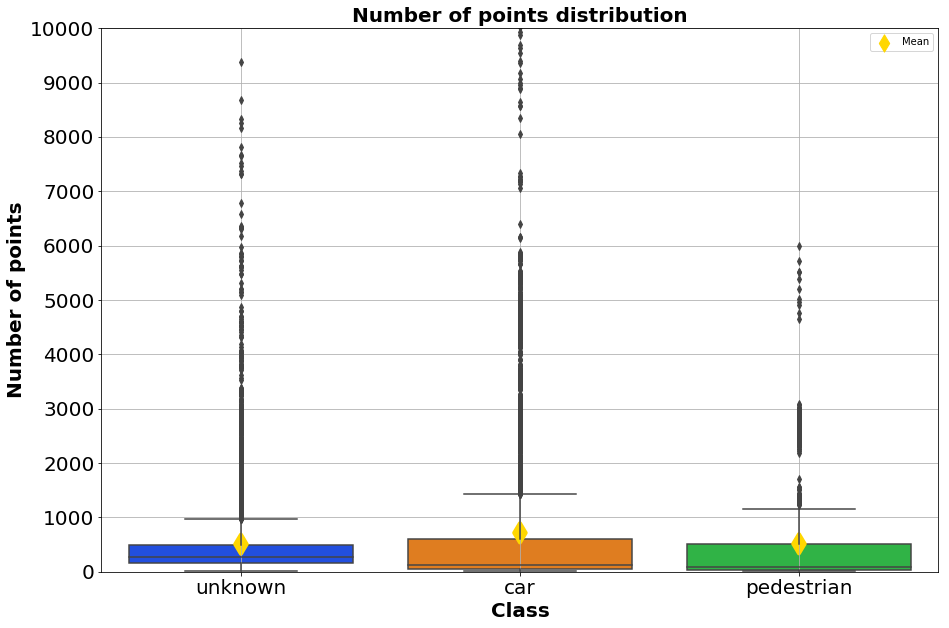

In [17]:
import seaborn as sns

import pandas as pd

import matplotlib.pyplot as plt



""" Dataset analysis """

class_list = ['unknown', 'car', 'pedestrian']

num_all_data = 0
for k in db:
    num_all_data += len(db[k])
    
print "Dataset: class / number / ratio \n"
for k in db:   
    print k, "\t/", len(db[k])  , "\t/" , "{:.02f}".format(float(len(db[k])) / float(num_all_data))

num_point_distribution = []
for k in db:      
    for c in db[k]:
        num_point_distribution.append([k, len(c)])
        
        
""" Visualization """
plt.close("all")
%matplotlib inline

fig, ax = plt.subplots(figsize = (15,10))

df = pd.DataFrame(num_point_distribution, columns = ['class', 'num_points'])

sns.boxplot(x = 'class', y = 'num_points', data=df, order= class_list, ax =ax, palette = 'bright')
sns.pointplot(x = 'class', y = 'num_points', data=df, linestyles='', scale=2, 
              color='gold', errwidth=0., capsize=0, markers='d', order= class_list, ax =ax, label = 'Mean')
ax.grid()
xticks = np.linspace(0, 10000, num = 11, endpoint = True)
plt.xticks(fontsize = 20)
plt.yticks(xticks, fontsize = 20)
ax.set_ylim(0,10000)
ax.set_title("Number of points distribution", fontsize = 20, fontweight='bold')
ax.set_xlabel("Class", fontsize = 20, fontweight='bold')
ax.set_ylabel("Number of points", fontsize = 20, fontweight='bold')
ax.plot()
ax.scatter(-1,-1, color='gold', marker='d',s = 150, label = 'Mean')
plt.legend()

## Data shuffle and divide

pedestrian 543
pedestrian 181
pedestrian 182
unknown 3553
unknown 1184
unknown 1185
car 3394
car 1132
car 1132


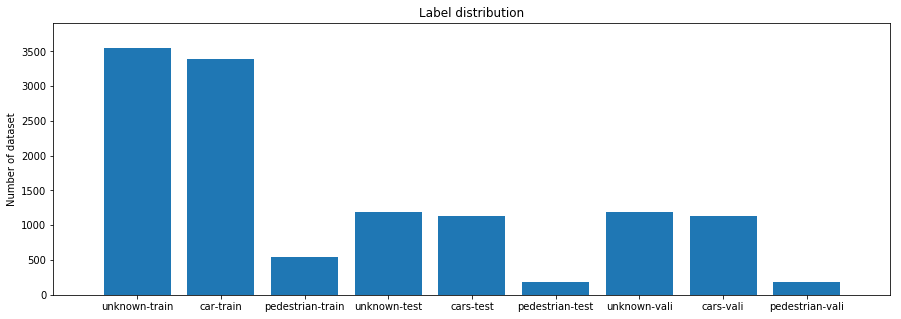

In [3]:
""" Shuffle and divide """

db_train = {}
db_vali = {}
db_test = {}

divide_ratio = [0.6, 0.8, 1.0]

class_list = ['unknown', 'car', 'pedestrian']

for c in class_list:
    
    db_train[c] = []
    db_vali[c] = []
    db_test[c] = []

    total_num =  len(db[c])
    
    shuffle_idx =np.arange(total_num)
    np.random.shuffle(shuffle_idx)

    db_train[c] = np.asarray(db[c])[ shuffle_idx[ 0:int(total_num * divide_ratio[0]) ] ]
    db_vali[c] = np.asarray(db[c])[ shuffle_idx[ int(total_num * divide_ratio[0]) : int(total_num * divide_ratio[1]) ] ]
    db_test[c] = np.asarray(db[c])[ shuffle_idx[ int(total_num * divide_ratio[1]) : ] ]

for k in db_train:
    print k , len(db_train[k])
    print k , len(db_vali[k])
    print k , len(db_test[k])


    
""" 
Data statistics
"""

import numpy as np
import matplotlib.pyplot as plt

y_val = []
y_val.append( len(db_train['unknown']) )
y_val.append( len(db_train['car']) )
y_val.append( len(db_train['pedestrian']) )
y_val.append( len(db_vali['unknown']) )
y_val.append( len(db_vali['car']) )
y_val.append( len(db_vali['pedestrian']) )
y_val.append( len(db_test['unknown']) )
y_val.append( len(db_test['car']) )
y_val.append( len(db_test['pedestrian']) )

x_name=('unknown-train', 'car-train', 'pedestrian-train',
        'unknown-test', 'cars-test', 'pedestrian-test',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

## Data normalization, conversion from dict to list, h5 save

In [4]:
import h5py
import numpy as np
import copy

# Data normalization and resampling
def NormalizeResample(data, num_sample):
    """ data is in N x ...
    we want to keep num_samplexC of them.
    if N > num_sample, we will randomly keep num_sample of them.
    if N < num_sample, we will randomly duplicate samples.
    """
  

    ## normalizing    
    min_val = np.min(data, axis = 0)
    
    data[:,0] = data[:,0] - min_val[0]
    data[:,1] = data[:,1] - min_val[1]
    data[:,2] = data[:,2] - min_val[2]
      
    max_val = np.max(data)
    
    data[:,0] = data[:,0] / max_val
    data[:,1] = data[:,1] / max_val
    data[:,2] = data[:,2] / max_val
                 
        
    ## resampling
    N = data.shape[0]
    if (N == num_sample):
        return data
    elif (N > num_sample):
        sample = np.random.choice(N, num_sample)
        return data[sample, ...]
    else:
        sample = np.random.choice(N, num_sample-N)
        dup_data = data[sample, ...]
        return np.concatenate([data, dup_data], 0)


def dict_to_data_label_heading(db, k_to_num):

    data_all = []
    class_label_all = []
    heading_label_all = []
    
    
    ## for augmentation
    yaw_rotate_from = 0.
    yaw_rotate_to = 360.
    yaw_step = 20.

    pitch_rotate_from = -1.
    pitch_rotate_to = 1.
    pitch_step = 3.
    

    yaw_iter = np.linspace(yaw_rotate_from, yaw_rotate_to, yaw_step, endpoint = False)
    pitch_iter = np.linspace(pitch_rotate_from, pitch_rotate_to, pitch_step)

    for k in db:

        data = []
        label = []
        heading = []
        
        l = k_to_num[k]

        for c in db[k]:
            
            c_aug, yawpitch = augmentation_rotation(c, yaw_iter, pitch_iter)
            
            for i_c in range ( len ( c_aug ) ) :
                data.append(c_aug[i_c])
                label.append(l)
                heading.append(yawpitch[i_c][0])
                
        data_all.extend( copy.deepcopy(data) )
        class_label_all.extend( copy.deepcopy(label) )
        heading_label_all.extend( copy.deepcopy(heading) )
        
    return data_all, class_label_all, heading_label_all



""" save function """
def save_h5_file(data_path, data, class_label, heading_label, 
                 data_dtype, class_label_dtype, heading_class_dtype, num_sample):
                 
    print "Total data:", len(data)
    print "Total class label:", len(class_label)
    print "Total heading label:", len(heading_label)
    
    total_num = len(data)
    
    np_data = np.zeros( ( total_num, num_sample, 3 ) )
    np_class_label = np.zeros( ( total_num, 1 ) )
    np_heading_label = np.zeros( ( total_num, 1 ) )
    
    for i in range( len(data) ):
        
        nrd = NormalizeResample( data[i], num_sample )
        
        np_data[i,:] = nrd.copy()
        np_class_label[i,] = class_label[i]
        np_heading_label[i,] = float(heading_label[i]) / 360.
        
    
    ## shuffle data
    idx = np.arange(len(data))
    
    np.random.shuffle(idx)

    np_data = np_data[idx,:]
    np_class_label = np_class_label[idx,:]   
    np_heading_label = np_heading_label[idx,:]   
    
    print "np_data", np_data.shape
    print "np_class_label", np_class_label.shape
    print "np_heading_label", np_heading_label.shape
    
    if os.path.exists(data_path):
        os.system('rm {}'.format(data_path))
        print "!! remove existing file !!"

    h5_train = h5py.File(data_path)
    
    h5_train.create_dataset('data', data=np_data, compression='gzip', compression_opts=4, dtype=data_dtype)
    h5_train.create_dataset('class', data=np_class_label, compression='gzip', compression_opts=1, dtype=class_label_dtype)
    h5_train.create_dataset('heading', data=np_heading_label, compression='gzip', compression_opts=4, dtype=heading_class_dtype)
    h5_train.close()
    print "[Generate] path: {}, \ndata shape: {}, label shape: {}, {}".format(data_path, str(np_data.shape), str(np_class_label.shape), str(np_heading_label.shape) )



## Augmentation by rotation

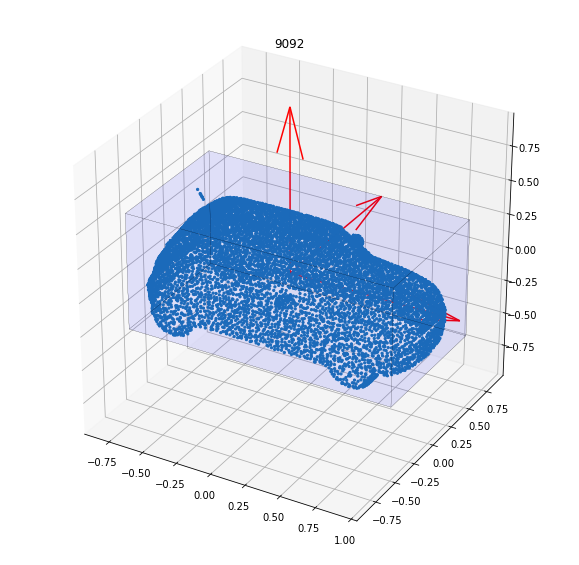

/home/kyungpyo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/kyungpyo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


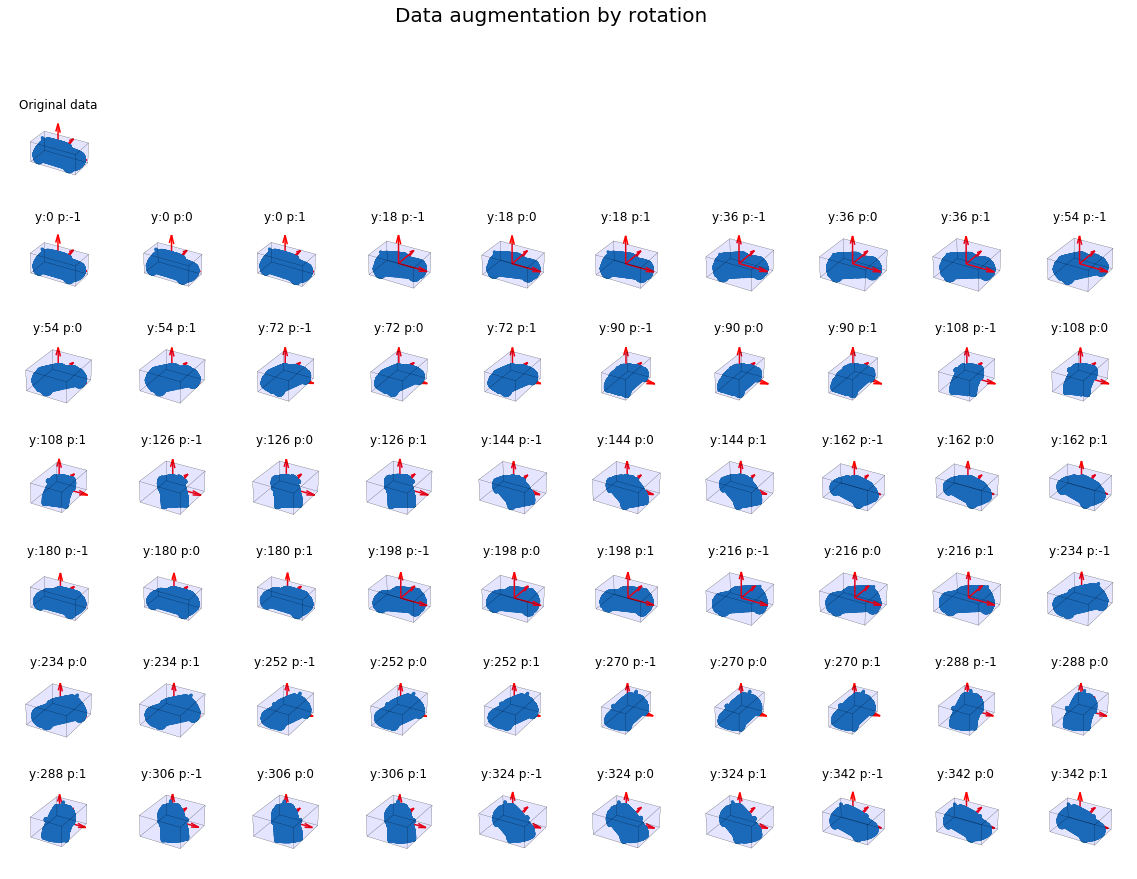

In [5]:
import os

import numpy as np

pc = np.load("/media/kyungpyo/SmartCarContest/MasterThesisProject/new_dataset/dataset/pointcloud_from_stl/car_np_point_align_align_surface_points/car_0037_align_align_se.npy")

pc -= np.mean(pc)
pc /= np.max(abs(pc))

%matplotlib inline
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_title("{}".format(len(pc)))
display_point_cloud_box_ax_test(ax, pc)
plt.show()



""" Augmentation - rotation (yaw) """

yaw_rotate_from = 0.
yaw_rotate_to = 360.
yaw_step = 20.

pitch_rotate_from = -1.
pitch_rotate_to = 1.
pitch_step = 3.

# numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)[source]

yaw_iter = np.linspace(yaw_rotate_from, yaw_rotate_to, yaw_step, endpoint = False)
pitch_iter = np.linspace(pitch_rotate_from, pitch_rotate_to, pitch_step)

def augmentation_rotation(cloud, yaw_iter, pitch_iter):
    
    cloud_aug = []
    yp = []
        
    for yaw in yaw_iter:

        yaw = yaw * np.pi / 180.0

        for pitch in pitch_iter:                       

            pitch = pitch * np.pi / 180.0

            yawMatrix = np.matrix([[np.cos(yaw), -np.sin(yaw), 0.],
                                [np.sin(yaw), np.cos(yaw), 0.],
                                [0., 0., 1.]])

            pitchMatrix = np.matrix([[np.cos(pitch), 0., np.sin(pitch)],
                                    [0., 1., 0.],
                                    [-np.sin(pitch), 0., np.cos(pitch)]])

            p_mean = np.mean(cloud, axis = 0)

            cloud[:,0] -= p_mean[0]
            cloud[:,1] -= p_mean[1]
            cloud[:,2] -= p_mean[2]

            np_pc_aug = np.array((pitchMatrix*yawMatrix*cloud.T).T)                                                    
            cloud_aug.append(np_pc_aug.copy())

            yp.append([yaw * 180. / np.pi, pitch * 180. / np.pi])
            
    return cloud_aug, yp



""" Test """
pc = np.load("/media/kyungpyo/SmartCarContest/MasterThesisProject/new_dataset/dataset/pointcloud_from_stl/car_np_point_align_align_surface_points/car_0037_align_align_se.npy")

cloud_aug, yp = augmentation_rotation(pc, yaw_iter, pitch_iter)



""" Display augmenation results - yaw, pitch direction """
%matplotlib inline

plt.close('all')
fig = plt.figure(figsize = (20,14))

# fig.subplots_adjust(left=0.02,top= 0.98,bottom=0.02,right=0.98,wspace=0.1,hspace=0.5)
fig.suptitle('Data augmentation by rotation', fontsize=20, horizontalalignment = 'center')
ax=fig.add_subplot(7,10,1, projection='3d')
ax = display_point_cloud_box_ax_test(ax, pc)
ax.set_title('Original data')
ax.axis('off')

for i,pc in enumerate(cloud_aug):
    ctr=i+11
    ax=fig.add_subplot(7,10,ctr, projection='3d')
    ax = display_point_cloud_box_ax_test(ax, pc)
    ax.axis('off')
    ax.set_title("y:{:.0f} p:{:.0f}".format(yp[i][0], yp[i][1]))

plt.show()


## Generation of h5 file

In [6]:
k_to_num = { "unknown":0 , "car":1, "pedestrian":2 }

d_train, cl_train, hl_train = dict_to_data_label_heading(db_train, k_to_num)
d_vali, cl_vali, hl_vali = dict_to_data_label_heading(db_vali, k_to_num)
d_test, cl_test, hl_test = dict_to_data_label_heading(db_test, k_to_num)

del db_train
del db_vali
del db_test

num_sample = 1024
data_dtype = 'float32'
class_label_dtype = 'uint8'
heading_label_dtype = 'float32'

/home/kyungpyo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/kyungpyo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


Total data: 449400
Total class label: 449400
Total heading label: 449400


MemoryError: 

In [8]:
save_h5_file('./vali.h5', d_vali, cl_vali, hl_vali, data_dtype, class_label_dtype, heading_label_dtype, num_sample)
save_h5_file('./test.h5', d_test, cl_test, hl_test, data_dtype, class_label_dtype, heading_label_dtype, num_sample)
save_h5_file('./train.h5', d_train, cl_train, hl_train, data_dtype, class_label_dtype, heading_label_dtype, num_sample)


Total data: 149820
Total class label: 149820
Total heading label: 149820


MemoryError: 

## Dataset evaluation


In [ ]:
import h5py

import os

data = []
class_label = []
heading_label = []

data_train_path = os.path.abspath('./train.h5')
data_vali_path = os.path.abspath('./vali.h5')
data_test_path = os.path.abspath('./test.h5')

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['class'][:]
    heading_label = f['heading'][:]
    return (data, class_label, heading_label)

data_train, class_label_train, heading_label_train = load_h5(data_train_path)
data_vali, class_label_vali, heading_label_vali = load_h5(data_vali_path)

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['label'][:]
    return (data, class_label)

data_test, class_label_test = load_h5(data_test_path)

data.append(data_train)
data.append(data_vali)
data.append(data_test)

class_label.append(class_label_train)
class_label.append(class_label_vali)
class_label.append(class_label_test)

heading_label.append(heading_label_train)
heading_label.append(heading_label_vali)
heading_label.append(heading_label_test)

In [ ]:
""" Data statistics"""

label_list = [0, 1, 2]

import numpy as np
import matplotlib.pyplot as plt

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(class_label[i] == label_list[j]))

x_name=('unknown-train', 'car-train', 'pedestrian-train',
        'unknown-test', 'cars-test', 'pedestrian-test',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [ ]:
""" Visualization Function """
from visualization import *
plt.close('all')
%matplotlib inline

fig = plt.figure()

""" Key list """
num_visu_object = 10

dataset_list = ['train', 'vali', 'test']
num_dataset = len(dataset_list)

class_list = ['unkown', 'car', 'pedestrian']
num_class = [0, 1, 2]


for i in range(num_dataset):
    
    fig = plt.figure(figsize = (num_visu_object*2, len(num_class)*2))
    fig.suptitle("Dataset - " + dataset_list[i], fontsize=20, horizontalalignment = 'center')
    

    for j in num_class:

        d = data[i]
        l = class_label[i]

        ## Search idx
        l_visu_idx = np.where(l == j)[0][:num_visu_object]
        
        for k in range(num_visu_object):
            
            ctr = k + 1 + 10 * j
            ax = fig.add_subplot(len(num_class), num_visu_object,ctr, projection='3d')
            resample_data = resample_point_cloud(d[l_visu_idx[k]],1.0)
            display_point_cloud_box_ax_test(ax, resample_data)
            plt.axis('off')